In [1]:
import json
from datetime import date
from datetime import datetime,timedelta
import plotly.figure_factory as ff
from copy import deepcopy
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#JUST CHANGE THIS CELL AND RUN ALL OTHERS
HOME = "./JPDC_results/"
EXPERIMENT = 1 #any one of 1,2,3 

In [3]:
if EXPERIMENT == 1:
    folder = "Expt-1"
else:
    folder = "Expt-2"
    if EXPERIMENT == 2:
        heft_version = "eager"
    elif EXPERIMENT == 3:
        heft_version = "dynamic"

In [4]:
def create_relative_timestamps(size,num_queues_gpu=1,num_queues_cpu=0,num_heads_on_cpu=0,folder='paramterised_dag_profiling',heft=False,heft_version="eager"):
    if not heft:
        with open(HOME+"{4}/{2}_GPU{0}_CPU{1}_{3}.json".format(num_queues_gpu,num_queues_cpu,size,num_heads_on_cpu,folder)) as f:
            timestamps = json.load(f)
    else:
        size = 2**size
        if heft_version == "eager":
            with open(HOME+"eager_heft/dynamic_heft_{0}_16.json".format(size)) as f:
                timestamps = json.load(f)
        elif heft_version == "dynamic":
            with open(HOME+"/dynamic_heft/dynamic_heft_{0}_16.json".format(size)) as f:
                timestamps = json.load(f)

    kernels = timestamps.keys()
    reference_device = {}
    reference_host = {}
    total_time = 0
    global_reference = None

    for kernel in kernels:
        device = timestamps[kernel]["device"]
        if device == 'gpu':
            t = timestamps[kernel]["write"]["device_start"]
        else:
            t = timestamps[kernel]["nd_range"]["device_start"]
        if t == -1:
            continue
        if not (device in reference_device):
            reference_device[device] = t
        else:
            reference_device[device] = min(reference_device[device],t)

        t = timestamps[kernel]["write"]["host_queued_end"]

        if not (device in reference_host):
            reference_host[device] = t
        else:
            reference_host[device] = min(reference_host[device],t)

        t = timestamps[kernel]["write"]["host_queued_start"]
        #print timestamps[kernel]["write"]["host_queued_end"]-timestamps[kernel]["write"]["host_queued_start"]
        if not global_reference:
            global_reference = t
        else:
            global_reference = min(global_reference,t)

    relative_timestamps = deepcopy(timestamps)

    # global_reference = None

    # for key,value in reference_host.items():
    #     if not global_reference:
    #         global_reference = value
    #     else:
    #         global_reference = min(value,global_reference)


    for kernel,kernel_timestamps in relative_timestamps.items():
        device = kernel_timestamps["device"]
        for event_type,event_timestamps in kernel_timestamps.items():
            #print(event_type)
            if event_type in ["device","cmdq"]:
                continue
            else:
                #continue
                for sub_event_type in event_timestamps:
                    if  sub_event_type[:4] == "host":
                        event_timestamps[sub_event_type] -= global_reference
                        continue
                    else:
                       event_timestamps[sub_event_type] = event_timestamps[sub_event_type] - reference_device[device] + reference_host[device] - global_reference
    #                     event_timestamps[sub_event_type] = event_timestamps[sub_event_type] - reference_device[device] + \
    #                     kernel_timestamps["write"]["host_queued_start"] - global_reference
                    total_time = max(total_time,event_timestamps[sub_event_type])



    #print "Total Time Taken - ",total_time
    #print(json.dumps(relative_timestamps,sort_keys=True,indent=1))          
    return total_time,relative_timestamps

In [5]:
size = 2
gains = []
sizes = []
gpu_queues = []
cpu_queues = []
best_times = []


    
if folder == 'Expt-1':
    sl,su = 1,17 #number of heads varies from 1,17 -> size fixed at 256
else:
    sl,su = 6,10 #number of heads is 16 -> size varies from 2**6 to 2**10
    
for size in range(sl,su):
    min_time = None
    min_config = {}
    all_configs = {}
    if folder == 'Expt-2':
        ul = 8
    else:
        ul = size
    
    if folder == 'Expt-1':
        print "In this block the transformer size is 256 (fixed), and number of heads is {}".format(size)
    else:
        print "In this block the transformer heads are fixed (16) and size is {}".format(2**size)
    
    default,_ = create_relative_timestamps(size,num_queues_gpu=1,num_queues_cpu=1,num_heads_on_cpu=0,folder=folder)
    for num_queues_gpu in range(1,6):
        for num_queues_cpu in range(1,6):
            for num_heads_on_cpu in range(0,ul):
                try:
                    total_time,_ = create_relative_timestamps(size,num_queues_gpu,num_queues_cpu,num_heads_on_cpu,folder=folder)
                    all_configs[(size,num_queues_cpu,num_queues_gpu,num_heads_on_cpu)] = total_time
                    if (not min_time) or (total_time<min_time):
                        min_time = total_time
                        min_config['num_heads_on_cpu'] = num_heads_on_cpu
                        min_config['num_queues_gpu'] = num_queues_gpu
                        min_config['num_queues_cpu'] = num_queues_cpu

                    #print "Num Queues - GPU {} CPU {} CPU Heads {}/{} Total Time {}".format(num_queues_gpu,num_queues_cpu,num_heads_on_cpu,size,total_time)
                except KeyboardInterrupt:
                    raise KeyboardInterrupt
                except Exception as e:
                    raise e
                    #print "Best Configuration for size {} is {}, %gain {}".format(size,min_config,100.0*(default-min_time)/default)
                    #raise e
    gain = 100.0*(default-min_time)/default
    
    if folder == 'Expt-1':
        print "Best Configuration for number of heads {} is {}, %gain {}".format(size,min_config,gain)
    else:
        print "Best Configuration for size {} and number of heads 16 is {}, %time {}".format(2**size,min_config,min_time)
        
    gains.append(gain)
    sizes.append(size)
    best_times.append(min_time)
    gpu_queues.append(min_config['num_queues_gpu'])
    cpu_queues.append(min_config['num_queues_cpu'])

In this block the transformer size is 256 (fixed), and number of heads is 1
Best Configuration for number of heads 1 is {'num_queues_cpu': 2, 'num_heads_on_cpu': 0, 'num_queues_gpu': 2}, %gain 8.24285345778
In this block the transformer size is 256 (fixed), and number of heads is 2
Best Configuration for number of heads 2 is {'num_queues_cpu': 2, 'num_heads_on_cpu': 0, 'num_queues_gpu': 2}, %gain 13.3323614506
In this block the transformer size is 256 (fixed), and number of heads is 3
Best Configuration for number of heads 3 is {'num_queues_cpu': 3, 'num_heads_on_cpu': 0, 'num_queues_gpu': 3}, %gain 14.1879568808
In this block the transformer size is 256 (fixed), and number of heads is 4
Best Configuration for number of heads 4 is {'num_queues_cpu': 3, 'num_heads_on_cpu': 0, 'num_queues_gpu': 4}, %gain 14.622886938
In this block the transformer size is 256 (fixed), and number of heads is 5
Best Configuration for number of heads 5 is {'num_queues_cpu': 3, 'num_heads_on_cpu': 0, 'num_que

In [6]:
if folder == "Expt-2":
    heft_times = []
    for size in range(sl,su):
        total_time,_ = create_relative_timestamps(size,heft=True,heft_version=heft_version)
        heft_times.append(total_time)


sizes = np.array(sizes)
gains = np.array(gains)
gpu_queues = np.array(gpu_queues)
cpu_queues = np.array(cpu_queues)
if folder == 'Expt-2':
    heft_times = np.array(heft_times)
    best_times = np.array(best_times)
    speedups_over_heft = heft_times/best_times
    real_sizes = 2**sizes

In [7]:
if folder == 'Expt-2':
    plt.xlabel(r'Size of Transformer - $\beta$')
    plt.ylabel('Speedup')
    plt.plot(real_sizes,speedups_over_heft,'bo-')
    #plt.axvline(10.5,color='r',linestyle='dashed')
    #plt.title(r'Speedups over HEFT vs Size of Transformer')
    plt.xscale('log',basex=2)
    plt.xlim(32,1024)
    #plt.xticks(real_sizes)
    #plt.plot(sizes,cpu_queues,'ro-')


    for i in range(len(sizes)):
        x = real_sizes[i]
        y = speedups_over_heft[i]
        if x > 10:
            label =  str(gpu_queues[i])+","+str(cpu_queues[i])
        else:
            label = str(gpu_queues[i])+","+str(0)
        y_offset = 10 if i%2 else 10
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(-2.5,y_offset), # distance from text to points (x,y)
                     ha='center',
                     fontsize = 8,
                     label = 'cq_config') 
    

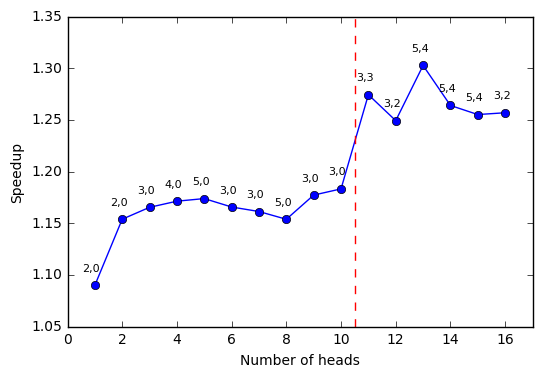

In [8]:
if folder == 'Expt-1':
    gains = np.array(gains)
    speedups = 1/(1-gains/100)
    plt.xlim(0,17)
    plt.xlabel('Number of heads')
    plt.ylabel('Speedup')
    plt.plot(sizes,speedups,'bo-')
    plt.axvline(10.5,color='r',linestyle='dashed')
    #plt.title('Speedups vs Number of Heads - (CQ_gpu, CQ_cpu)')
    #plt.plot(sizes,cpu_queues,'ro-')


    for i in range(len(sizes)):
        x = sizes[i]
        y = speedups[i]
        if x > 10:
            label =  str(gpu_queues[i])+","+str(cpu_queues[i])
        else:
            label = str(gpu_queues[i])+","+str(0)
        y_offset = 10 if i%2 else 10
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(-2.5,y_offset), # distance from text to points (x,y)
                     ha='center',
                     fontsize = 8,
                     label = 'cq_config') 


In [9]:
if folder == 'Expt-2':
    best_time,best_timestamps = create_relative_timestamps(size=9,num_queues_gpu=4,num_queues_cpu=1,num_heads_on_cpu=1,folder=folder)
    heft_time,heft_timestamps = create_relative_timestamps(size=9,heft=True,heft_version=heft_version)
    

In [10]:
def to_time_delta(timestamp):
    now = datetime.now()
    second = int(timestamp)
    microsecond = (timestamp - float(second))*1e6
    now = now.replace(hour=0, minute=0, second=second, microsecond=int(microsecond))
    return now


def plot_per_cq(relative_timestamps,total_time,title):
    df = []
    kernels = {}




    for kernel,events in relative_timestamps.items():
        dev = events["device"]
        cq = events["cmdq"]
        #print kernel,cq
        Task = "<b>{}_{}</b>".format(dev,cq)
        ##events -> write,read,nd_range
        ##event  -> device_queued,device_start,device-end
    #         for interval in intervals:
    #             Resource=event
    #             Start = now + timedelta(seconds=interval[0])
    #             Finish = now + timedelta(seconds=interval[1])
    #             df.append(dict(Task=Task,Start=Start,Finish=Finish,Resource=Resource))


        if events["write"]["device_start"] > 0:
            write_overhead_start = to_time_delta(events["write"]["host_queued_start"])
            write_event_start = write_overhead_end = to_time_delta(events["write"]["device_start"])
            write_event_end = to_time_delta(events["write"]["device_end"])
            #df.append(dict(Task=Task,Start=write_overhead_start,Finish=write_overhead_end,Resource='overhead'))
            df.append(dict(Task=Task,Start=write_event_start,Finish=write_event_end,Resource='<b>write</b>'))



        if kernel.startswith('FFC'):
            exec_resource = '<b>gemm</b>'
        elif "transpose" in kernel:
            exec_resource = '<b>transpose</b>'
        elif 'softmax' in kernel:
            exec_resource = '<b>softmax</b>'
        else:
            exec_resource = '<b>copy</b>'

        exec_event_start  = to_time_delta(events["nd_range"]["device_start"])
        exec_event_end = to_time_delta(events["nd_range"]["device_end"])
        df.append(dict(Task=Task,Start=exec_event_start,Finish=exec_event_end,Resource=exec_resource))


        if events["read"]["device_start"] > 0:
            read_event_start = to_time_delta(events["read"]["device_start"])
            read_overhead_start = read_event_end = to_time_delta(events["read"]["device_end"])
            df.append(dict(Task=Task,Start=read_event_start,Finish=read_event_end,Resource='<b>read</b>'))



    colors = {'<b>copy</b>': '#ff00ff',
              '<b>read</b>': (1, 0.9, 0.16),
              '<b>write</b>': 'rgb(0, 255, 100)',
             'overhead': 'rgb(0, 0, 255)',
             '<b>gemm</b>': '#dd3069',
             '<b>transpose</b>': '#a9a9d9',
             '<b>softmax</b>': '#3399cc'}

    df.sort(key = lambda x : x['Task'])
    fig = ff.create_gantt(df, colors=colors, index_col='Resource', show_colorbar=True,
                          group_tasks=True,width=1000,height=600)

    fig.layout['xaxis']['tickformat'] = '<b>%-S.%3f</b>'
    fig.layout['title'] = title
    fig.layout['xaxis_title'] = '<b>Time (seconds)</b>'
    fig.layout['yaxis_title'] = '<b>Command Queue</b>'
    #fig.layout['xaxis_range']=[to_time_delta(0),to_time_delta(total_time)]
    fig.layout['xaxis_range'] = [to_time_delta(0),to_time_delta(max(best_time,heft_time)+0.1)]
    #fig.layout['xaxis_range'] = [to_time_delta(0),to_time_delta(1.2)]
    #fig.layout['paper_bgcolor'] = 'rgb(255,255,255)'
    fig.layout['plot_bgcolor'] = 'rgb(255,255,255)'

    fig.layout['xaxis']['linecolor'] = 'rgb(0,0,0)'
    fig.layout['xaxis']['mirror'] =True
    fig.layout['xaxis']['ticks'] = 'outside'
    fig.layout['xaxis']['showline'] = True

    fig.layout['yaxis']['linecolor'] = 'rgb(0,0,0)'
    fig.layout['yaxis']['mirror'] =True
    fig.layout['yaxis']['ticks'] = 'outside'
    fig.layout['yaxis']['showline'] = True
    
    fig.layout['font'] = dict(
            family="Courier New, monospace",
            size=22,
            color="#000000")
    fig.update_traces(mode='lines', line_color='black',line_width=0.5,selector=dict(fill='toself'),dy=0.0001,dx=0.0001)

    
    fig.show()
    return fig

In [11]:
if folder == "Expt-2":
    fig = plot_per_cq(best_timestamps,best_time,'Cluster Sch. -  Total Time {0:.2f} s'.format(best_time))

In [12]:
if folder == "Expt-2":
    if EXPERIMENT == 2:
        title = "Eager Sch."
    else:
        title = "HEFT Sch."
    fig = plot_per_cq(heft_timestamps,heft_time,'{0} - Total Time {1:.2f} s'.format(title,heft_time))
        